In [1]:
import bias

import numpy as nd
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingRegressor  # HistGradientBoostingRegressor
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# ----- Configuration Variables -----

NUMERIC_FEATURES = ["year", "author_seniority", "num_aggl_publications"]
#CATEGORIAL_FEATURES = ["author_gender", "author_country", "author_classification", "author_journal_classification", "author_continent"]
CATEGORIAL_FEATURES = ["author_gender", "author_classification_cluster", "author_journal_classification", "author_continent"] # classification erstmal nicht als feature betrachten
SAMPLING_COLUMN = "num_aggl_publications_cluster"      # name of the feature / column that is used to sample the test data into equally sized data sets
TARGET_FEATURE = "num_aggl_single_publications" # name of the feature / clumn that will be predicted
NUM_FOLDS = 10
RANDOM_STATE = 1

#MODEL = HistGradientBoostingRegressor(max_depth=6, max_leaf_nodes=64)
MODEL = GradientBoostingRegressor(n_estimators=140, min_samples_leaf=5, max_depth=15)

# -----------------------------------

FEATURE_PREPROCESSOR = ColumnTransformer(
    n_jobs=3,
    transformers=[
        ('num',
            Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='median')),
                #('scaler', StandardScaler())
            ]), NUMERIC_FEATURES),
        ('cat', OneHotEncoder(), CATEGORIAL_FEATURES)  # OneHotEncoder(drop="first")
    ])

## Data import and preprocessing

## Sampling

## Generate 'normal' and 'switched' data sets

In [102]:
import joblib
MODEL = joblib.load("num_publications_sampling_gradient_boosting_equal_gender_count_model.pkl")

## Finalize test set with fictional authors

In [30]:
test_data = bias.preprocess_dataset("zbmath_fictional_authors.csv",
        categorial_rows=CATEGORIAL_FEATURES + ["author_classification"],
        drop_rows=["author_id", "num_aggl_collaborators", "num_aggl_collaborations"])
test_data = bias.cluster_column(test_data, bias.PUBLICATION_COUNT_CLUSTERING, "num_aggl_publications", newcolumn="num_aggl_publications_cluster")
test_data = bias.cluster_column(test_data, bias.EGONET_1_CLUSTERING, "author_classification", newcolumn="author_classification_cluster")
#test_data = data.loc[data.year>=1970]
#test_data["single_publication_perc"] = data["num_aggl_single_publications"]*100/data["num_aggl_publications"]
test_data.head(15)

,year,author_gender,author_country,author_seniority,author_classification,author_journal_classification,num_aggl_publications,num_aggl_single_publications,author_continent,num_aggl_publications_cluster,author_classification_cluster
0,1990,f,CN,5,65,KAT 1,3,0,NA,c) 3,PDE / Numerical / Physics
1,1990,m,CN,5,65,KAT 1,3,0,NA,c) 3,PDE / Numerical / Physics
2,2000,f,CN,5,65,KAT 1,3,0,NA,c) 3,PDE / Numerical / Physics
3,2000,m,CN,5,65,KAT 1,3,0,NA,c) 3,PDE / Numerical / Physics
4,2010,f,CN,5,65,KAT 1,3,0,NA,c) 3,PDE / Numerical / Physics
5,2010,m,CN,5,65,KAT 1,3,0,NA,c) 3,PDE / Numerical / Physics
6,1990,f,CN,10,65,KAT 1,6,0,NA,f) 6,PDE / Numerical / Physics
7,1990,m,CN,10,65,KAT 1,6,0,NA,f) 6,PDE / Numerical / Physics
8,2000,f,CN,10,65,KAT 1,6,0,NA,f) 6,PDE / Numerical / Physics
9,2000,m,CN,10,65,KAT 1,6,0,NA,f) 6,PDE / Numerical / Physics


In [12]:
test_data = test_data.drop("num_aggl_publications_cluster", axis=1)
X_test, _ = bias.X_y_split(test_data, TARGET_FEATURE)
X_test_t = FEATURE_PREPROCESSOR.transform(X_test)
X_test_t = Df(X_test_t, columns=feature_names, index=X_test.index)

## Shap value analysis

In [13]:
import shap
explainer = shap.TreeExplainer(MODEL)
test_explanation = explainer(X_test_t)

In [14]:
test_shap_values = explainer.shap_values(X_test_t)

In [15]:
shap_test_interaction = explainer.shap_interaction_values(X_test_t)

In [16]:
gender_combined_shap_values = nd.concatenate([test_shap_values, nd.sum(test_shap_values[:, 3:5], axis=1).reshape(test_shap_values.shape[1],1)], axis=1)

In [71]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import SubplotSpec

def create_subtitle(fig: plt.Figure, grid: SubplotSpec, title: str, fontsize=14):
    "Sign sets of subplots with title"
    row = fig.add_subplot(grid)
    # the '\n' is important
    row.set_title(f'{title}\n', fontsize=fontsize)
    # hide subplot
    row.set_frame_on(False)
    row.axis('off')

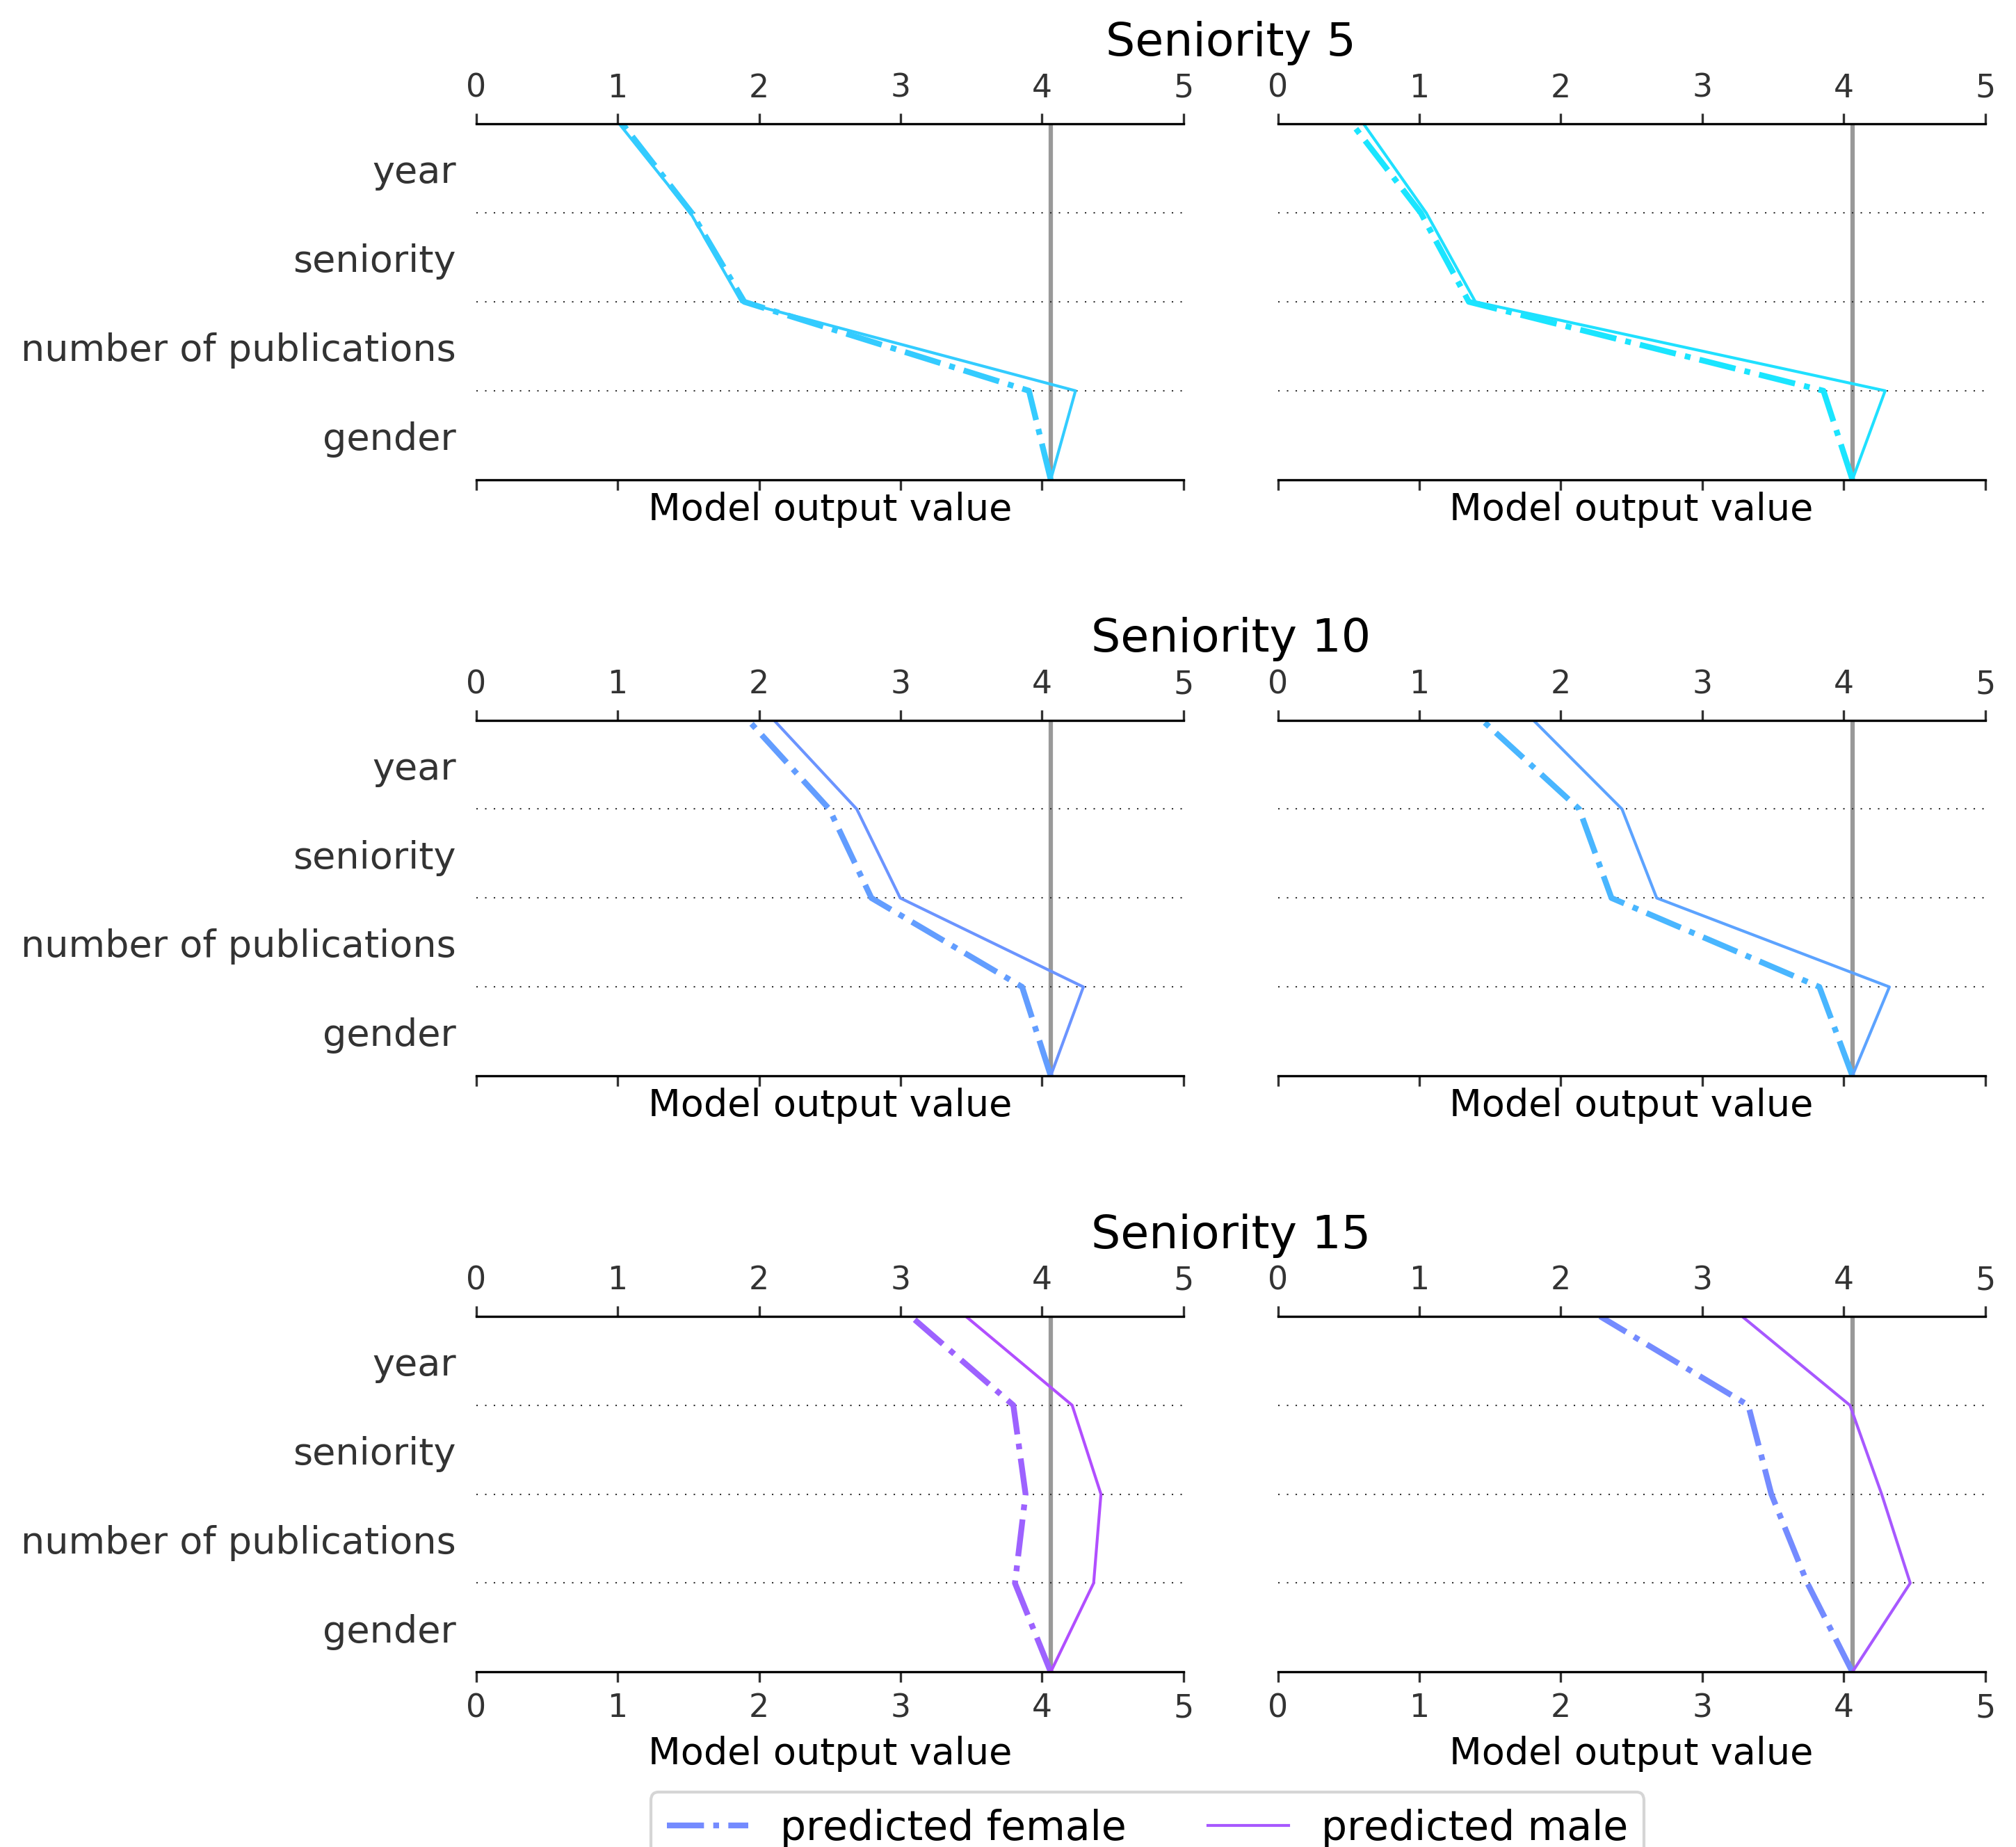

In [99]:
# Seniority-Effect

idxs = [4, 10, 16]
forder = [36,2,1,0] + list(range(3, 36))
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10,9), dpi=300, sharex=True)


for i, idx in enumerate(idxs):
    fig.sca(fig.axes[2*i])
    
    shap.decision_plot(explainer.expected_value,
                       gender_combined_shap_values[idx:idx+2],
                       feature_names=["year", "seniority", "number of publications"] + [""]*33 + ["gender"],
                       #feature_names=[""]*37,
                       highlight=0,
                       feature_order=forder,
                       feature_display_range=range(3, -1, -1),
                       show=False,
                       auto_size_plot=False,
                       xlim=(0,5),
                       color_bar=False,
                       plot_color="cool",)
    box = fig.gca().get_position()
    fig.gca().set_position([box.x0, box.y0, box.width * 1.05, box.height])
    
    fig.sca(fig.axes[2*i+1])
    
    shap.decision_plot(explainer.expected_value,
                       gender_combined_shap_values[idx+18:idx+18+2],
                       #feature_names=["year", "seniority", "number of publications"] + [""]*33 + ["gender"],
                       feature_names=[""]*37,
                       highlight=0,
                       feature_order=forder,
                       feature_display_range=range(3, -1, -1),
                       show=False,
                       auto_size_plot=False,
                       xlim=(0,5),
                       color_bar=False,
                       plot_color="cool",
                       legend_labels=["female", "male"])
    fig.gca().get_legend().set(visible=False)
    box = fig.gca().get_position()
    fig.gca().set_position([box.x0, box.y0, box.width * 1.05, box.height])

legend = fig.gca().get_legend()
fig.legend(legend.get_lines(), ["predicted female", "predicted male"], loc="lower center", bbox_to_anchor=(0.55, -0.02), ncol=2, fontsize=14, frameon=True)

grid = plt.GridSpec(3, 2)
create_subtitle(fig, grid[0, ::], 'Seniority 5')
create_subtitle(fig, grid[1, ::], 'Seniority 10')
create_subtitle(fig, grid[2, ::], 'Seniority 15')
fig.tight_layout()
#plt.show()
plt.savefig("shap_single_seniority_effect.png", dpi=300, bbox_inches='tight')

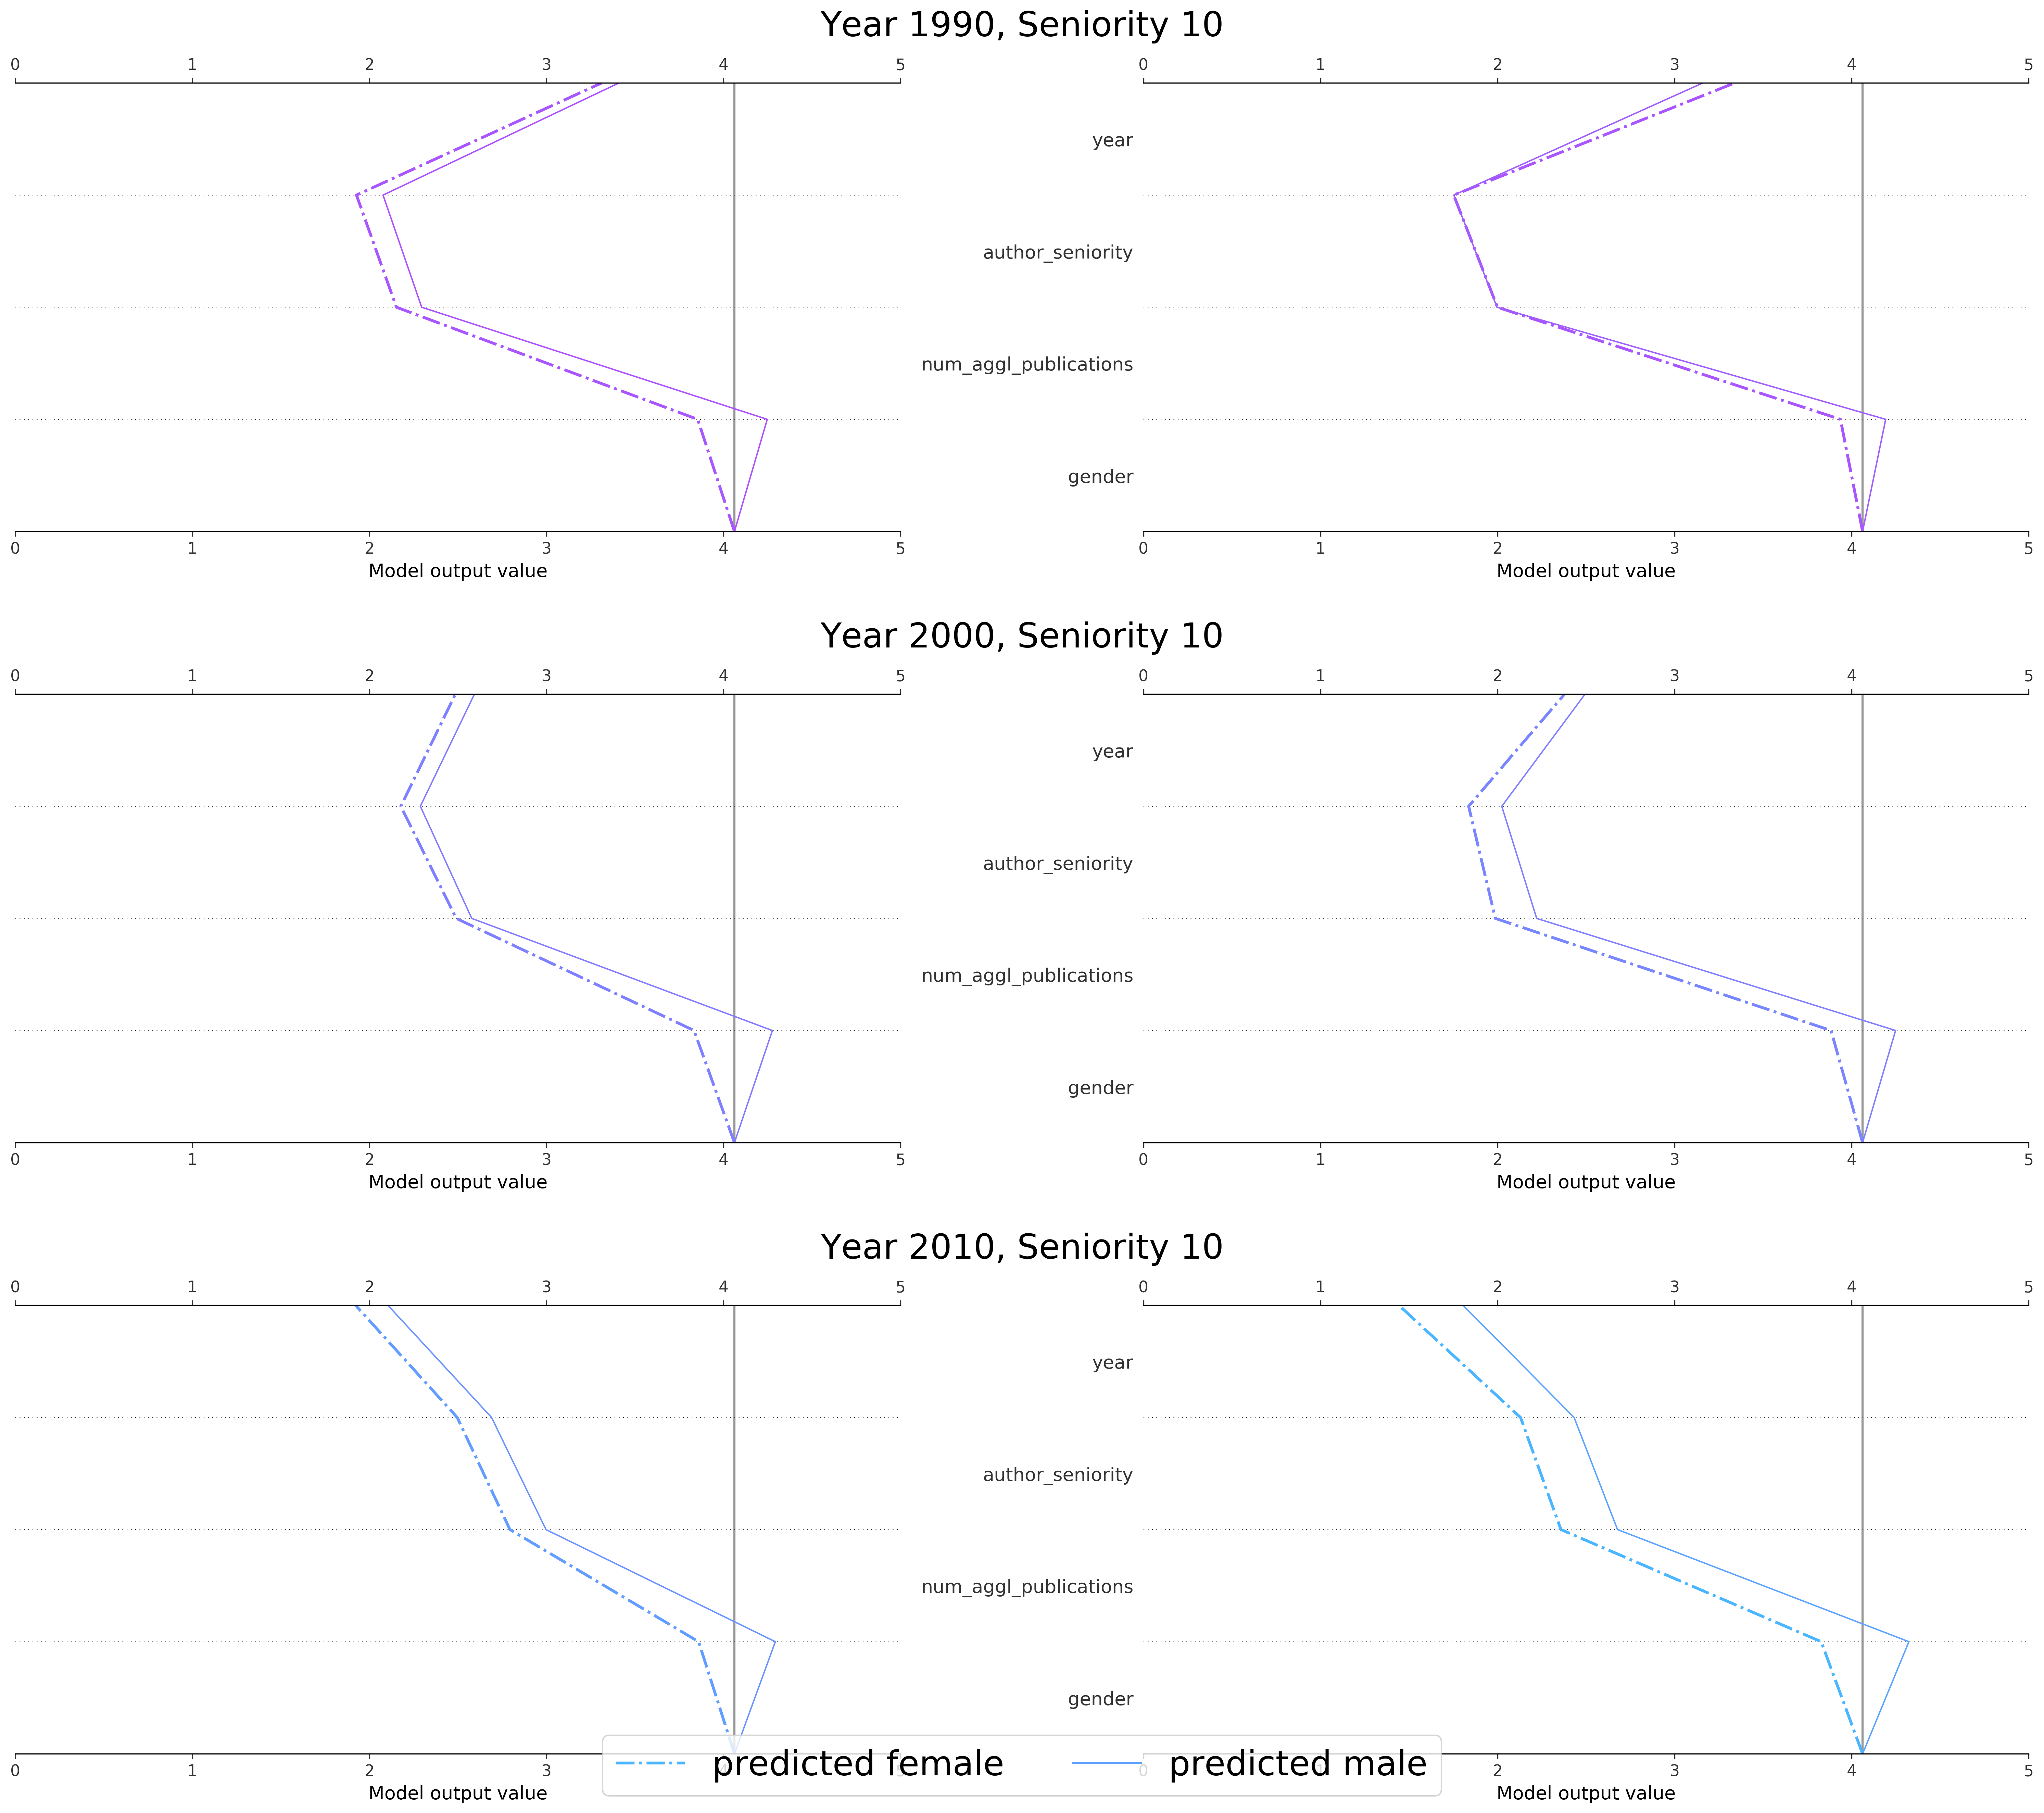

In [29]:
# Year-Effect

idxs = [6, 8, 10]
forder = [36,2,1,0] + list(range(3, 36))
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20,18), dpi=300)

for i, idx in enumerate(idxs):
    fig.sca(fig.axes[2*i])
    shap.decision_plot(explainer.expected_value,
                       gender_combined_shap_values[idx:idx+2],
                       #feature_names=feature_names + ["gender"],
                       feature_names=[""]*37,
                       highlight=0,
                       feature_order=forder,
                       feature_display_range=range(3, -1, -1),
                       show=False,
                       auto_size_plot=False,
                       xlim=(0,5),
                       color_bar=False,
                       plot_color="cool")
    
    fig.sca(fig.axes[2*i+1])
    shap.decision_plot(explainer.expected_value,
                       gender_combined_shap_values[idx+18:idx+18+2],
                       feature_names=feature_names + ["gender"],
                       highlight=0,
                       feature_order=forder,
                       feature_display_range=range(3, -1, -1),
                       show=False,
                       auto_size_plot=False,
                       xlim=(0,5),
                       color_bar=False,
                       plot_color="cool",
                       legend_labels=["female", "male"])
    fig.gca().get_legend().set(visible=False)

legend = fig.gca().get_legend()
fig.legend(legend.get_lines(), ["predicted female", "predicted male"], loc="lower center", ncol=2, fontsize=24, borderaxespad=0.)

grid = plt.GridSpec(3, 2)
create_subtitle(fig, grid[0, ::], 'Year 1990, Seniority 10')
create_subtitle(fig, grid[1, ::], 'Year 2000, Seniority 10')
create_subtitle(fig, grid[2, ::], 'Year 2010, Seniority 10')
fig.tight_layout()
plt.show()

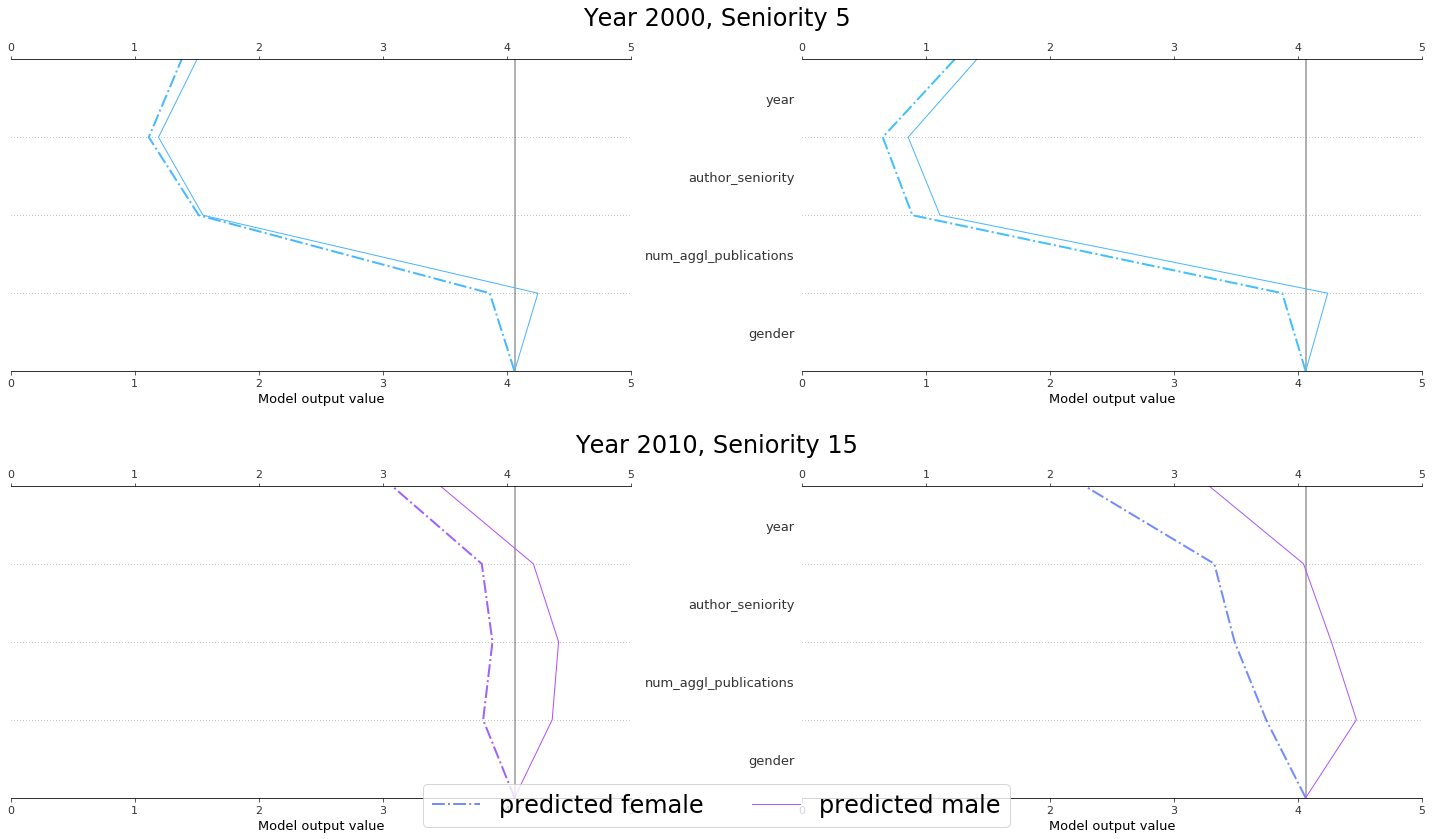

In [27]:
# Career-Effect

idxs = [2, 16]
forder = [36,2,1,0] + list(range(3, 36))
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,12))

for i, idx in enumerate(idxs):
    fig.sca(fig.axes[2*i])
    shap.decision_plot(explainer.expected_value,
                       gender_combined_shap_values[idx:idx+2],
                       #feature_names=feature_names + ["gender"],
                       feature_names=[""]*37,
                       highlight=0,
                       feature_order=forder,
                       feature_display_range=range(3, -1, -1),
                       show=False,
                       auto_size_plot=False,
                       xlim=(0,5),
                       color_bar=False,
                       plot_color="cool")
    
    fig.sca(fig.axes[2*i+1])
    shap.decision_plot(explainer.expected_value,
                       gender_combined_shap_values[idx+18:idx+18+2],
                       feature_names=feature_names + ["gender"],
                       highlight=0,
                       feature_order=forder,
                       feature_display_range=range(3, -1, -1),
                       show=False,
                       auto_size_plot=False,
                       xlim=(0,5),
                       color_bar=False,
                       plot_color="cool",
                       legend_labels=["female", "male"])
    fig.gca().get_legend().set(visible=False)

legend = fig.gca().get_legend()
fig.legend(legend.get_lines(), ["predicted female", "predicted male"], loc="lower center", ncol=2, fontsize=24)

grid = plt.GridSpec(2, 2)
create_subtitle(fig, grid[0, ::], 'Year 2000, Seniority 5')
create_subtitle(fig, grid[1, ::], 'Year 2010, Seniority 15')
fig.tight_layout()

plt.show()